# Финальный проект по курсу Data Science
(на основании данных из соревнования "Santander Customer Transaction Prediction" с kaggle)

https://www.kaggle.com/c/santander-customer-transaction-prediction/overview

# Введение


**Цель проекта:** обучить модели трёх разных типов, которые на основании входящих переменных будут предсказывать совершит ли покупатель транзакцию или нет (задача бинарной классификации), произвести сравнение полученных моделей.

**Входные данные:** тестовый набор данных из 200 тысяч транзакций, с 200 сотнями обезличенных переменных, которые по своей структуре аналогичны реальным данным.

**Инструменты для работы:** python3 и все необходимые библиотеки (numpy, pandas, catboost, matplotlib, seaborn, sklearn).

**Оценка результатов:** оценка результатов модели будет производиться, как и в оригинальном соревновании с помощью метрики AUC.

# Раздел 1. Анализ входящих данных, подготовка данных к обучению модели

### **Подключение модулей и загрузка файлов для обработки**

Для начала загрузим и подключим все необходимые библиотеки и данные из файла для дальнейшего анализа.

In [ ]:
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import catboost
import sklearn
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

input_data = pd.read_csv('./data/train.csv', sep=',')
random_seed=42

### **Обработка данных:**

Перед началом работы посмотрим на наши данные с помощью метода describe:

In [ ]:
input_data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

Наши данные содержат 201 столбец, где столбец target - содержит класс, который нам нужно будет научиться предсказывать и 200 стобцов содержащих обезличенные переменные.

Проверим, присутствуют ли в наших данных пропущенные значения и повторящиеся строки. Для этого подсчитаем количество нулевых значений во всех столбцах:

In [ ]:
input_data.isnull().sum().sum()

0

Теперь проверим наш датасет на наличие дублирующихся значений.

In [ ]:
input_data.duplicated().sum()

0

Отлично, нулевых значений и дублирующихся строк нет, поэтому нет необходимости совершать какие-либо действия по обработке данных.

Теперь нам нужно посмотреть, какими типами данных являются значения в наших столбцах.

In [ ]:
input_data.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

In [ ]:
input_data.dtypes.value_counts()

float64    200
object       1
int64        1
dtype: int64

Поскольку все столбцы имеют тип числа с плавающей точкой, то никаких дополнительных преобразований нам не потребуется и мы можем приступить к анализу имеющихся данных.



### **Анализ данных**


В данном разделе посмотрим на распределение класса, который нам необходимо предсказать, проверим признаки на мультиколлинеарность, посмотрим на распределение нескольких признаков на графиках.

Для начала посмотрим на распределение результирующей переменной в нашей выборке данных:

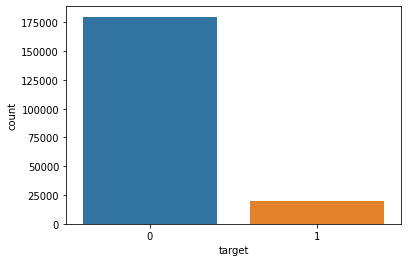

In [ ]:
sns.countplot(x='target', data=input_data)


Из графика видим, что выборка несбалансирована - покупателей совершивших транзакцию (класс 1) значительно меньше, чем покупателей не совершивших транзакцию (0 класс). В нашем случае (бинарная классификация), несбалансированность классов не должна оказать влияния на модель и метрика ROC-AUC хорошо подходит для оценки результатов (т.к. мы будем предсказывать вероятность принадлежности к классу 1).

Поскольку у нас достаточно большое количество признаков, то возможно, что некоторые из них могут коррелировать между собой(мультиколлинеарность), что в свою очередь может привести к переобучению, избыточной сложности модели и другим негативным последствиям. Для исключения таких возможностей произведём несколько действий по оценке мультиколлинеарности.

Построим матрицу парных корреляций для проверки наличия мультиколлинеарности между нашими признаками: возьмём модуль от всех её компонентов, отсортируем по возрастанию и посмотрим на 10 наиболее тесно связанных между собой признаков:

In [ ]:
corr_matrix = input_data.drop(columns=['target', 'ID_code']).corr()
correlations = corr_matrix.abs().unstack().sort_values(ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
200,var_139,var_26,0.009844
201,var_26,var_139,0.009844
202,var_148,var_53,0.009788
203,var_53,var_148,0.009788
204,var_165,var_81,0.009714
205,var_81,var_165,0.009714
206,var_81,var_174,0.009490
207,var_174,var_81,0.009490
208,var_189,var_183,0.009359
209,var_183,var_189,0.009359


Для наглядности построим график:

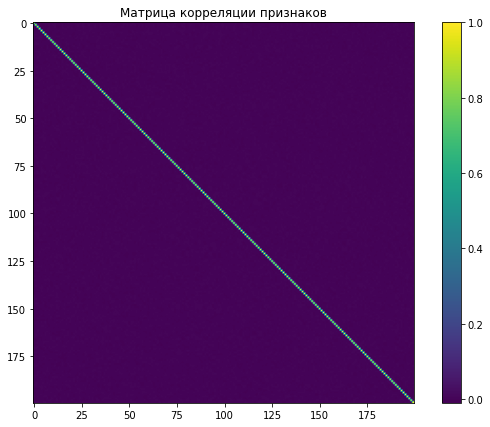

In [ ]:
plt.pyplot.figure(figsize=(10,7))
plt.pyplot.title('Матрица корреляции признаков');
plt.pyplot.imshow(corr_matrix)
plt.pyplot.colorbar()

Корреляция между факторами незначительная, т.к. наибольшее значение не превышает 0.05.

Теперь посмотрим на определитель матрицы парной корреляции:

In [ ]:
np.linalg.det(corr_matrix)

0.8862833806480873

Поскольку определитель получился достаточно близким к единице, это подтверждает факт того, что мультиколлинеарность между факторами незначительная, никаких переменных исключать не нужно. 

Проверим распределение наших данных: построим графики для первых 5 переменных, узнаем максимальные и минимальные значения по всем признакам.

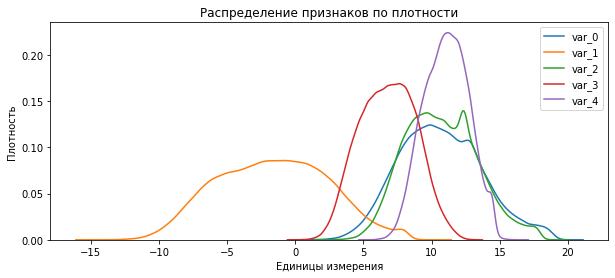

In [ ]:
first_five_features = input_data.columns[2:7].to_list()
fig, ax = plt.pyplot.subplots(1, 1, figsize=(10, 4))
plt.pyplot.title('Распределение признаков по плотности')
plt.pyplot.ylabel('Плотность')
plt.pyplot.xlabel('Единицы измерения')
for feature in first_five_features:
  sns.kdeplot(input_data[feature], ax=ax, label=feature,legend=True)
plt.pyplot.legend(loc = 'upper right')

Из графиков видно, что распределение большей части признаков приближено к нормальному, не имеет выраженных ассиметрий и эксцессов.

Извлечём названия наших признаков в отдельный список,  и посмотрим на максимальные и минимальные значения по всем признакам.

In [ ]:
max = float('-inf')
min = float('inf')
features = input_data.drop(columns=['target', 'ID_code']).columns.to_list()
for feature in features:
  if (input_data[feature].max() > max):
    max = input_data[feature].max()
  if (input_data[feature].min() < min):
    min = input_data[feature].min()
print("Максимальное значение по всем признакам: ", max)
print("Минимальное значение по всем признакам: ", min)

Максимальное значение по всем признакам:  74.0321
Минимальное значение по всем признакам:  -90.2525


Как мы видим из максимального и минимального значения, все наши данные имеют один порядок, и нет признаков, которые бы сильно выбивались по значениям.

Для дальнешей работы разделим наши тренировочные данные на 3 выборки(пропорция 80:10:10): тренировочную(train sample), тестовую (test sample) и валидационную(valid sample). Первые 2 будут использоваться для обучения, а последнюю используем для оценки качества полученной модели. 

In [ ]:
data_y = input_data[['target']]
data_x = input_data.drop(columns=['target', 'ID_code'])

In [ ]:
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(data_x, data_y, test_size=0.2, random_state=random_seed)
test_x, val_x, test_y, val_y = sklearn.model_selection.train_test_split(test_x, test_y, test_size=0.5, random_state=random_seed)

# Раздел 2. Обучение моделей

Обучим модели трёх разных типов: основанную на градиентном бустинге (CatboostClassifier), основанную на методе случайных лесов (RandomForest) и логистическую регрессию (LogisticRegression).
Метод случайных лесов и градиентный бустинг являются более сложными ансамблевыми методами, в то время как логистическая регрессия является более простым, но достаточно эффективным методом.

### **Catboost classifier из модуля catboost**

Подготовим наши данные к работе с моделью, для этого обернём их в соответствующие классы:

In [ ]:
train_pool = catboost.Pool(
    data=catboost.FeaturesData(num_feature_data=train_x.to_numpy(dtype='float32')),
    label=train_y,
)
test_pool = catboost.Pool(
    data=catboost.FeaturesData(num_feature_data=test_x.to_numpy(dtype='float32')),
    label=test_y,
)
val_pool = catboost.Pool(
    data=catboost.FeaturesData(num_feature_data=val_x.to_numpy(dtype='float32')),
    label=val_y,
)

Зададим необходимые параметры:

In [ ]:
params_cb = {'iterations':100000,
    'early_stopping_rounds':1000,
    'loss_function':'Logloss',
    'eval_metric':'AUC',
    'task_type':'GPU',
    'use_best_model':True,
    'random_seed':random_seed}

In [ ]:
cat_boost_classifier = catboost.CatBoostClassifier(**params_cb)
cat_boost_classifier.fit(train_pool, eval_set=test_pool)

С помощью валидационной выборки произведём оценку полученной модели:

In [ ]:
preds_prob_cb = cat_boost_classifier.predict(val_pool, prediction_type='Probability')
print( "sklearn auc = ", roc_auc_score(val_y, preds_prob_cb[:,1]) )


sklearn auc =  0.894499395329687


Для визуализации полученных результатов построим ROC-кривую, для этого воспользуемся методом get_roc_curve и получим необходимые данные:

Text(0.5, 0, 'False Positive Rate')

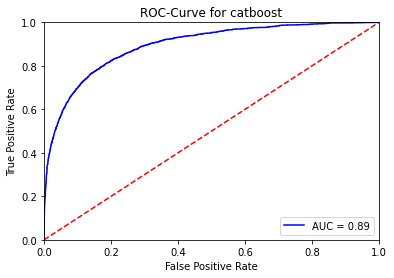

In [ ]:
fpr_cb, tpr_cb, threshods_cb = metrics.roc_curve(val_y, preds_prob_cb[:,1])
roc_auc_cb = metrics.auc(fpr_cb, tpr_cb)
plt.pyplot.title('ROC-Curve for catboost')
plt.pyplot.plot(fpr_cb, tpr_cb, 'b', label = 'AUC = %0.2f' % roc_auc_cb)
plt.pyplot.legend(loc = 'lower right')
plt.pyplot.plot([0, 1], [0, 1],'r--')
plt.pyplot.xlim([0, 1])
plt.pyplot.ylim([0, 1])
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.xlabel('False Positive Rate')

### **Forest of randomized trees from sklearn**  

Задаем необходимые параметры и запускаем процесс обучения модели:

In [ ]:
params_rf = {'random_state':random_seed,
          }
sklearn_random_forest = RandomForestClassifier(**params_rf)
sklearn_random_forest.fit(train_x, train_y.T.to_numpy()[0,:])

Получаем оценку модели и строим необходимый график

In [ ]:
preds_prob_rf = sklearn_random_forest.predict_proba(val_x)
print( "sklearn auc = ", roc_auc_score(val_y, preds_prob_rf[:,1]) )

sklearn auc =  0.8150141066458504


Text(0.5, 0, 'False Positive Rate')

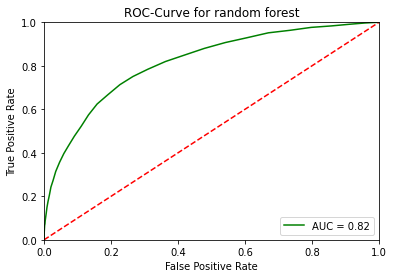

In [ ]:
fpr_rf, tpr_rf, threshods_rf = metrics.roc_curve(val_y, preds_prob_rf[:,1])
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)
plt.pyplot.title('ROC-Curve for random forest')
plt.pyplot.plot(fpr_rf, tpr_rf, 'g', label = 'AUC = %0.2f' % roc_auc_rf)
plt.pyplot.legend(loc = 'lower right')
plt.pyplot.plot([0, 1], [0, 1],'r--')
plt.pyplot.xlim([0, 1])
plt.pyplot.ylim([0, 1])
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.xlabel('False Positive Rate')

### **Logistic regression from sklearn** 

Зададим параметры для модели и запустим её процесс обучения:


In [ ]:
params_ll = {'random_state':random_seed,
          'solver':'liblinear',
          }
sklearn_logreg = LogisticRegression(**params_ll)
sklearn_logreg.fit(train_x, train_y.T.to_numpy()[0,:])

Произведём оценку параметров:

In [ ]:
preds_prob_lr = sklearn_logreg.predict_proba(val_x)
print( "sklearn auc = ", roc_auc_score(val_y, preds_prob_lr[:,1]) )

sklearn auc =  0.8545854060182715


Построим график:

Text(0.5, 0, 'False Positive Rate')

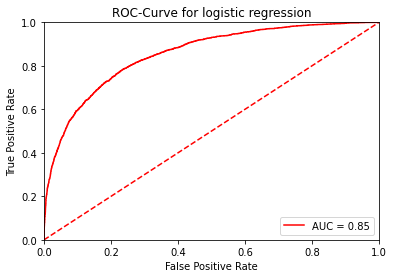

In [ ]:
fpr_lr, tpr_lr, threshods_lr = metrics.roc_curve(val_y, preds_prob_lr[:,1])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
plt.pyplot.title('ROC-Curve for logistic regression')
plt.pyplot.plot(fpr_lr, tpr_lr, 'r', label = 'AUC = %0.2f' % roc_auc_lr)
plt.pyplot.legend(loc = 'lower right')
plt.pyplot.plot([0, 1], [0, 1],'r--')
plt.pyplot.xlim([0, 1])
plt.pyplot.ylim([0, 1])
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.xlabel('False Positive Rate')

### **Сравнение моделей**

Исходя из полученных результатов можем сделать следующие выводы: все три модели даже с базовыми параметрами имеют достаточно высокую точность, при этом более простая логистическая регрессия показала лучший результат относительно метода случайных деревьев, а если ещё принять во внимание "тяжесть" обучения модели, её вес после дампа, то возможно на первое место и выйдет логистическая регрессия.

Для наглядности отразим на одном графике результаты всех трёх моделей:

Text(0.5, 0, 'False Positive Rate')

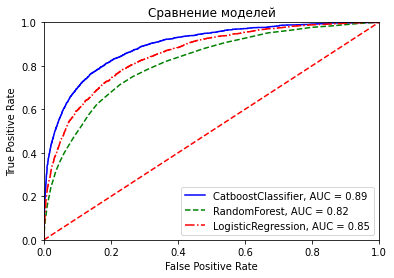

In [ ]:
plt.pyplot.title('Сравнение моделей')
plt.pyplot.plot(fpr_cb, tpr_cb, label = 'CatboostClassifier, AUC = %.2f' % roc_auc_cb, c='blue', ls='-')
plt.pyplot.plot(fpr_rf, tpr_rf, label = 'RandomForest, AUC = %.2f' % roc_auc_rf, c='green', ls='--')
plt.pyplot.plot(fpr_lr, tpr_lr, label = 'LogisticRegression, AUC = %.2f' % roc_auc_lr, c='red', ls='-.')
plt.pyplot.legend(loc = 'lower right')
plt.pyplot.plot([0, 1], [0, 1],'r--')
plt.pyplot.xlim([0, 1])
plt.pyplot.ylim([0, 1])
plt.pyplot.ylabel('True Positive Rate')
plt.pyplot.xlabel('False Positive Rate')

# Раздел 3.  Post-hok анализ и выводы

Произведём анализ полученных результатов. Воспользуемся методом get_feature_importance у catboost classifiera для получения важности признаков:

In [ ]:
feature_importance = pd.DataFrame(features.copy(), columns=['feature_name'])
feature_importance['feature_importance'] = cat_boost_classifier.get_feature_importance()
feature_importance = feature_importance.sort_values(by='feature_importance', ascending=False)
best_features = feature_importance[feature_importance['feature_importance'] > 1]
unimportant_features = feature_importance[feature_importance['feature_importance'] < 0.15]

Посмотрим на список наиболее значимых параметров (чей вклад в общую долю составляет более 1%):

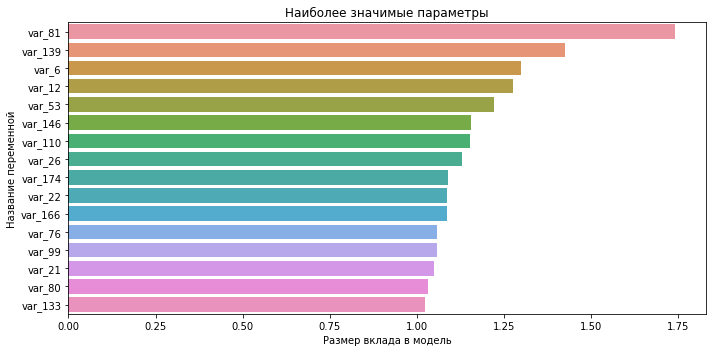

In [ ]:
plt.pyplot.figure(figsize=(10,5))
sns.barplot(x="feature_importance", y="feature_name", data=best_features)
plt.pyplot.title('Наиболее значимые параметры')
plt.pyplot.ylabel('Название переменной')
plt.pyplot.xlabel('Размер вклада в модель')
plt.pyplot.tight_layout()

Так же взглянем на параметры, чей вклад в общую долю составляет меньше 0.15

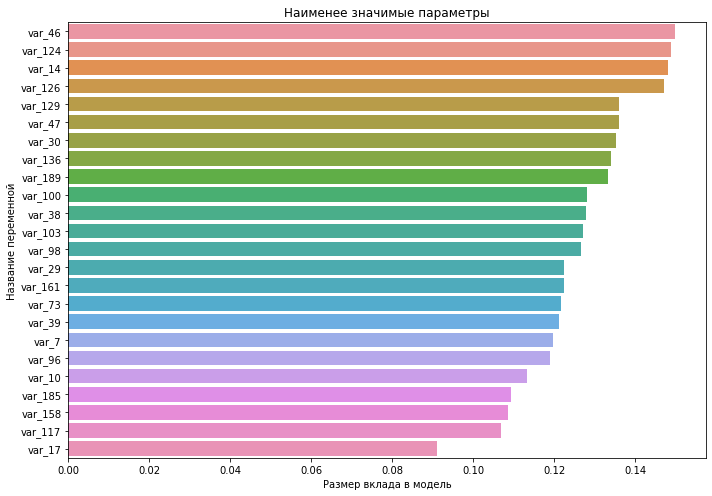

In [ ]:
plt.pyplot.figure(figsize=(10,7))
sns.barplot(x="feature_importance", y="feature_name", data=unimportant_features)
plt.pyplot.title('Наименее значимые параметры')
plt.pyplot.ylabel('Название переменной')
plt.pyplot.xlabel('Размер вклада в модель')
plt.pyplot.tight_layout()

Построим графики распределения для 5 наиболее важных и 5 наименее значимых признаков с разделением по результирующему фактору.

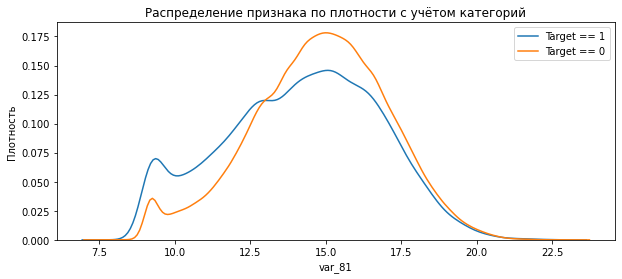

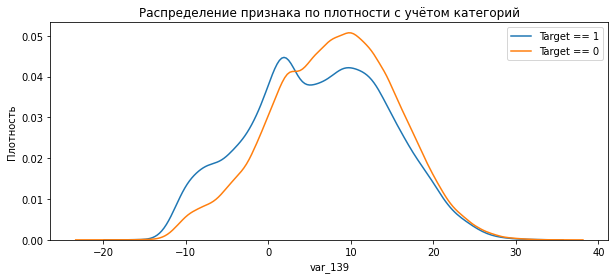

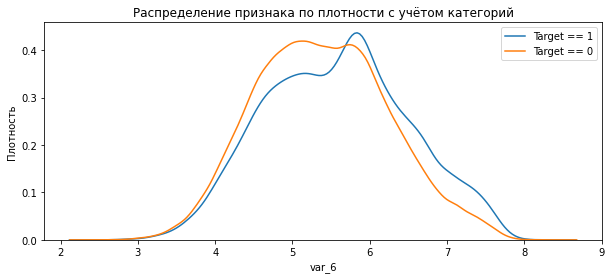

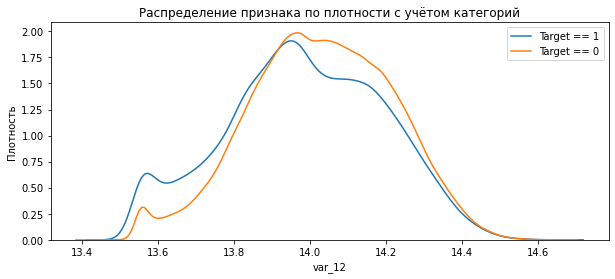

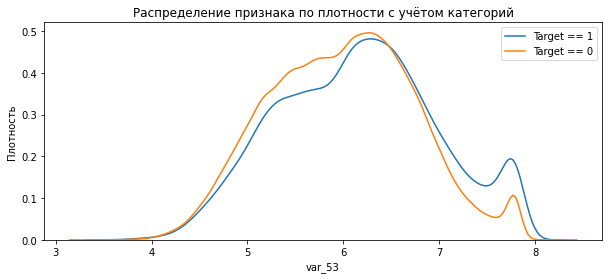

In [ ]:
best_features_names = best_features['feature_name'][0:5]
for feature in best_features_names:
  fig, ax = plt.pyplot.subplots(1, 1, figsize=(10, 4))
  plt.pyplot.title('Распределение признака по плотности с учётом категорий')
  plt.pyplot.ylabel('Плотность')
  sns.kdeplot(input_data[input_data['target'] == 1][feature], ax=ax, label='Target == 1',legend=True)
  sns.kdeplot(input_data[input_data['target'] == 0][feature], ax=ax, label='Target == 0',legend=True)
  plt.pyplot.legend(loc = 'upper right')

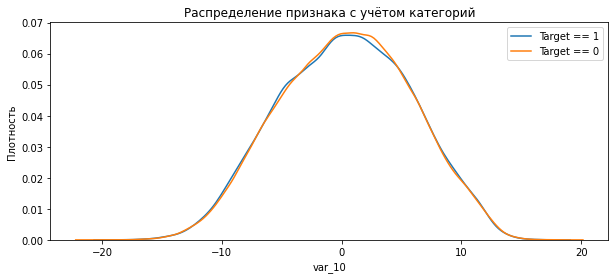

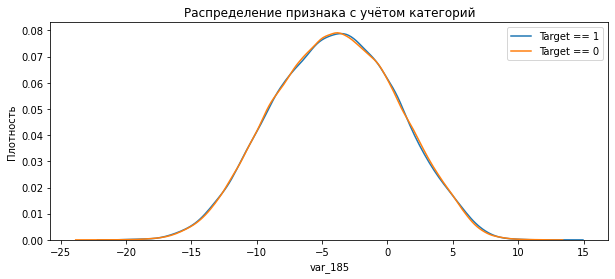

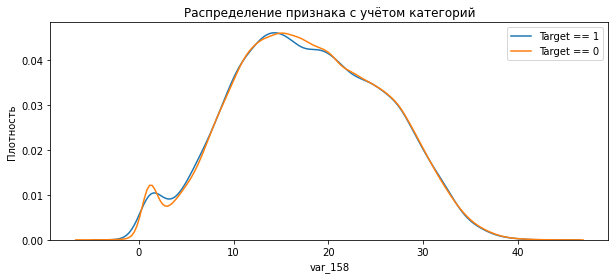

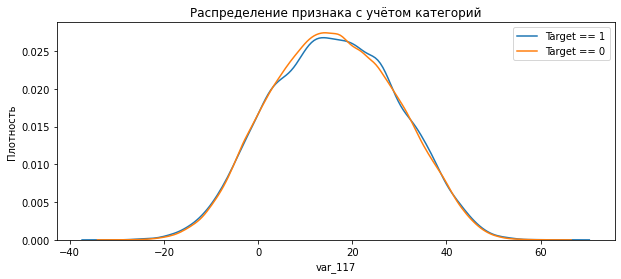

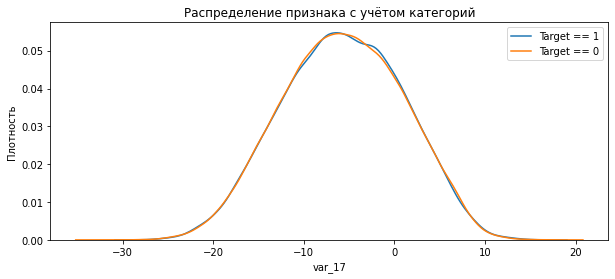

In [ ]:
unimportant_features_names = unimportant_features['feature_name'][-5:]
for feature in unimportant_features_names:
  fig, ax = plt.pyplot.subplots(1, 1, figsize=(10, 4))
  plt.pyplot.title('Распределение признака с учётом категорий')
  plt.pyplot.ylabel('Плотность')
  sns.kdeplot(input_data[input_data['target'] == 1][feature], ax=ax, label='Target == 1')
  sns.kdeplot(input_data[input_data['target'] == 0][feature], ax=ax, label='Target == 0')
  plt.pyplot.legend(loc = 'upper right')

Из построенных графиков видно, что для более значимых признаков изначально были заметные различия по плотности распределения для разных классов, в отличии от признаков, которые были оценены как менее значимые. Соответственно, наша модель выучила зависимости на тех признаках, которые содержали какую-либо информацию, позволяющую отличить два наших класса.

# Заключение


Подведём итог нашей работы.

Входящие данные были исследованы на пропуски, дублирующиеся значения, но никаких преобразований не потребовалось.

После первичной обработки был произведён анализ, который не показал наличие мультиколлинеарности, или сколько-нибудь значимой связи между какими-нибудь из признаков. При этом, рассмотренные признаки имели распределение, близкое к нормальному и лишь незначительно отличались друг от друга по порядку значений.

После обрабоки и анализа данных были обучены три различные модели: градиентный бустинг (модуль catboost), случайные деревья (модуль sklearn),  логистическая регрессия (модуль sklearn). Все три модели "из коробки" показали хорошие результаты: 

> CatBoostClassifier = 0.89

> LogisticRegression = 0.85

> RandomForest = 0.81

Лучше всего себя показала модель основанная на градиентном бустинге над решающими деревьями, при этом более простой метод в виде логистической регрессии показал лучшие результаты на валидационной выборке, нежели более сложный метод случайного леса. 

В качестве post-hok анализа были проведены попытки улучшить результаты градиентного бустинга с помощью нескольких методов (удаление из датасета нескольких наименее значимых переменных, добавление новых переменных с помощью различных методов), однако методы либо ухудшали модель, либо приносили лишь незначительный прирост на несколько десятитысячных по метрике AUC.

Таким образом, нам удалось получить наилучший результат по метрике ROC AUC  = 0.89 с помощью модели CatBoostClassifier.